In [1]:
import json
import pandas as pd

In [2]:
f = open('./logins.json')
logins = json.load(f)
logins = pd.DataFrame(logins)
logins.loc[:, 'login_time'] = pd.to_datetime(logins.login_time, format='%Y%m%d %H:%M:%S')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


## Part 1

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [3]:
t = logins.login_time
t15_int = logins.groupby(pd.Grouper(key="login_time", freq='15min')).size().to_frame(name='Count')
t15_int.head()

,Count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


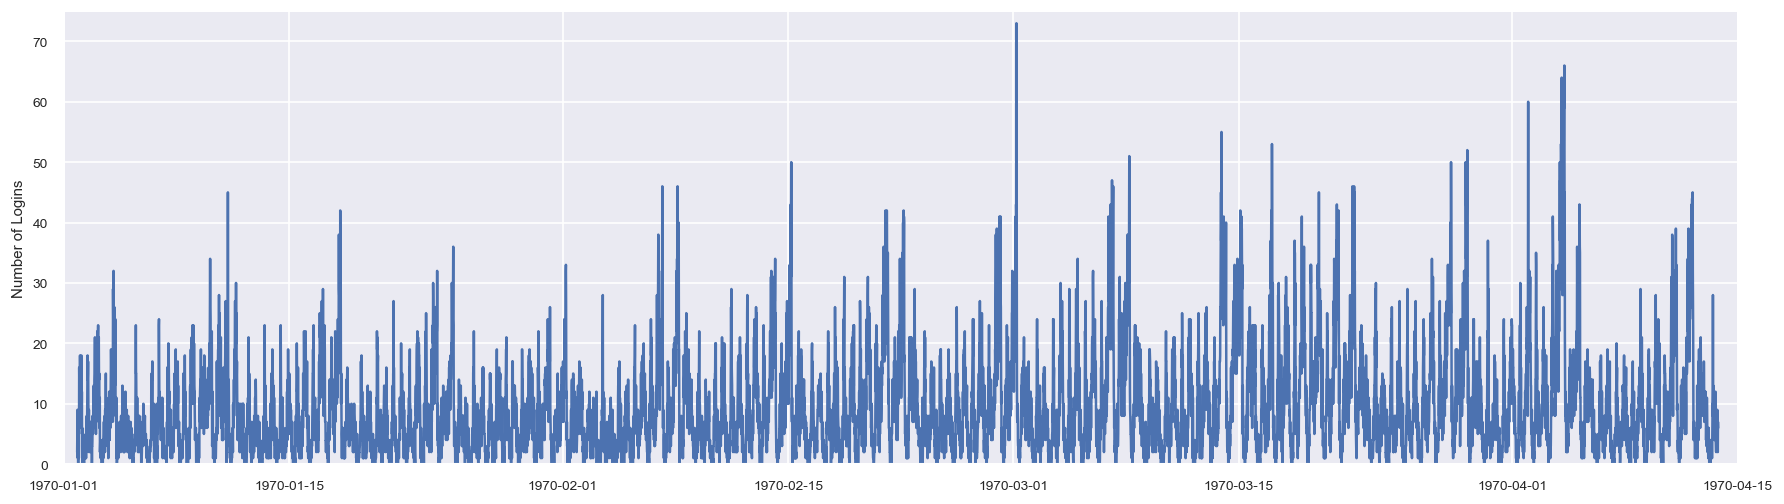

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pp

sns.set(font_scale=.75)
fig, ax = pp.subplots(figsize=(18, 5), dpi=120)
ax.plot(t15_int)
ax.set_xlim([pd.Timestamp(year=1970, month=1, day=1), pd.Timestamp(year=1970, month=4, day=15)])
ax.set_ylim([0, 75])
ax.set_ylabel('Number of Logins');

15 minute intervals per each day over the 4 month period indicates that there is a sinusoidal pattern.

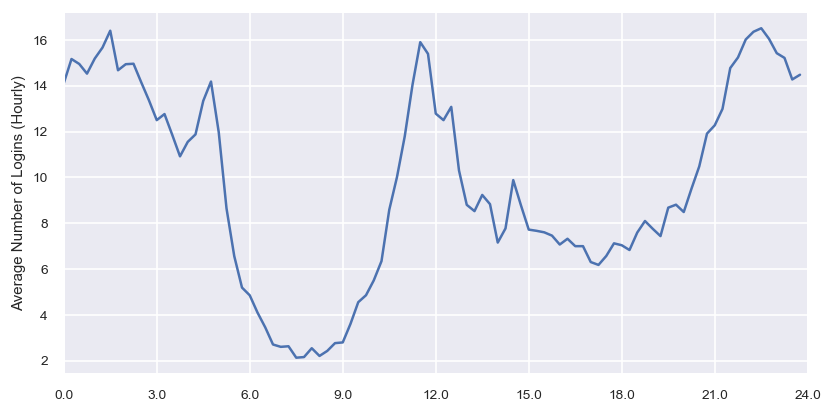

In [5]:
th_int = logins.groupby([t.dt.date, (t.dt.hour*60 + t.dt.minute) // 15]).count()
fig, ax = pp.subplots(figsize=(8, 4), dpi=120)
ax.plot(th_int.unstack().mean(axis=0).values)
ax.set_xlim([0, 96])
ax.set_xticks(np.linspace(0, 24, 9) * 60 / 15)
ax.set_xticklabels(list(map(str, np.linspace(0, 24, 9))))
ax.set_ylabel('Average Number of Logins (Hourly)');

During the night time and noon time, the number of logins have its peak

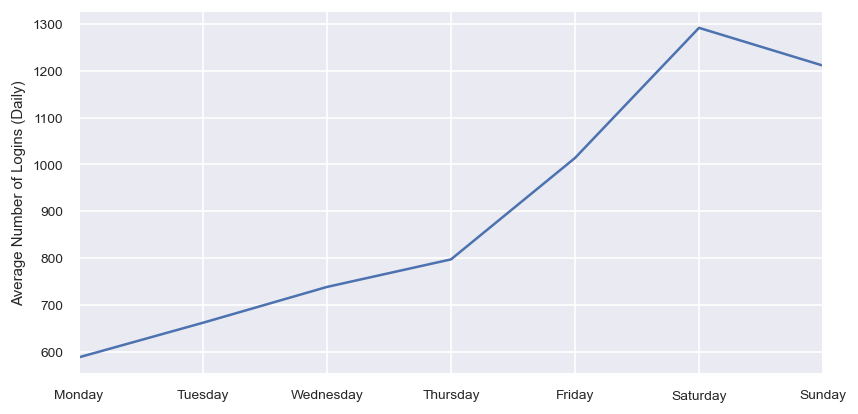

In [6]:
td_int = logins.groupby([t.dt.date, t.dt.dayofweek]).count()
fig, ax = pp.subplots(figsize=(8, 4), dpi=120)
ax.plot(td_int.unstack().mean(axis=0).values)
ax.set_xlim([0, 6])
ax.set_xticks(np.linspace(0, 6, 7))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_ylabel('Average Number of Logins (Daily)');

The spikes in user logins occur overwhelmingly on the weekends, which makes sense since many people use ride share apps to go to parties or bars, which are frequented mostly on the weekends.

## Part 2

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
**There would be two ways to track the effectiveness of this campaign. One would be to track the locations of the drivers using smartphone apps, and see the percentage of time during working hours that they spend in either city. Another way to track effectiveness would be to calculate how many drivers get reimbursement for the tolls during time they spent driving during their working hours, however this may not be effective because this variable will automatically jump from zero to something greater than zero, and will therefore be statistically significant and not informative since it is basically guaranteed. Location should be tracked. One thing to keep in mind is that working hours will differ depending on the city that the driver is predominantly driving in, due to the different circadian rhythms of the cities. Unless the driver does not need sleep, their activity will probably remain unchanged during the week even with toll reimbursement in place. Therefore, since people are very active on the weekends usually, and assuming driver location can be tracked, we propose tracking the location of the driver during the weekend as the variable of interest for the experiment.**

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    * How you will implement the experiment?
    * What statistical test(s) you will conduct to verify the significance of the observation?
    * How you would interpret the results and provide recommendations to the city operations team along with any caveats?
**As for statistical testing, bootstrap testing can be used, but a parametric test using the normal distribution will be better. Under the Central Limit Theorem, given a sufficiently large sample size, the sampling distribution of the mean will approach the normal distribution. We can use the normal distribution over the t-distribution, despite not knowing the population variance, because we will have a high number of degrees of freedom in a large urban population. We will employ a z-test to find the difference in means.**

**Steps of experiment:**
- Take a random sample of no less than 100 drivers
- Calculate the percentage time that they spend in each city on the weekends
- Implement the toll reimbursement policy for a set period and notify the drivers
- After the period is complete, sample the same drivers and calculate the percentage time they spend driving in each city on the weekends, again.
- Using a Z-test for proportions, at a chosen confidence level (99%), test the samples under the following setup
    - H0: There is no difference in the mean proportions of times spent in each city
    - Ha: There is a statistically significant difference in the mean proportions of times spent in each city

**It is important that this experiment be conducted on normal weekends that are not holidays and with no major events unless said events are ordinary, to prevent from artificially inflating the results. Confidence Intervals should be generated for the mean proportions as well in order to characterize the change in proportions over the test, if any. Also note that the higher the sample size, the greater chance of their being a statistically significant difference detected, even if that statistical significance does not translate to practical significance. The results of the experiment should be interpreted in that light.**

**If the percentage of time spent in the non-dominant city goes up with statistical significance, then the toll reimbursement has been effective in driving this effort. As for prediction of the profit results, there must be a comparison in the end between the total cost of the toll reimbursement vs the increased profit from having drivers available in both cities. The toll reimbursement could be effective and still lose money for the company. It is critical that this final step is taken.**

## Part 3

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. 

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. 

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

**Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?**

In [7]:
file = 'ultimate_data_challenge.json'
with open(file) as f:
    data = json.loads(f.read())
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [9]:
# Break down trip counts by percentage
df_tripcounts = df['trips_in_first_30_days'].value_counts(normalize=True)
df_tripcounts.head()

0    0.30780
1    0.28216
2    0.14804
3    0.07576
4    0.05124
Name: trips_in_first_30_days, dtype: float64

In [10]:
# What percentage of drivers are retained?
np.sum(df_tripcounts.iloc[1:])

0.6921999999999999

In [11]:
# Drop rows with no phone information, since we cannot infer that without building a predictive model
df = df.drop(df[df.phone.isna()==True].index, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    41578 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [12]:
df['avg_rating_by_driver'].describe()

count    49406.000000
mean         4.777861
std          0.447114
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [13]:
df['avg_rating_of_driver'].describe()

count    41578.000000
mean         4.601467
std          0.617377
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [14]:
# Fill missing values by averaging the mean and median
fill_val = (4.777861+5) / 2
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(value=fill_val)

# Fill missing values with median value
fill_val = (4.9+4.601467) / 2
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(value=fill_val)

In [15]:
# Inspect data after cleaning, everything looks to be in order
# We have a clean dataset with minimal reduction in its size
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


Active users are defined as having any activity in the preceding 30 days. Though the take home challenge writeup does not indicate the current date, we can infer the latest date in the dataset as the current date for our purposes and calculate "active" users based on that date.

In [16]:
# Convert to timestamp
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [17]:
# Set current date 
current_date = df['last_trip_date'].max()

In [18]:
df['active'] = df['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


Only 37.6% of users are active at the end of the six month period. Let's build a predictive model to identify the factors associated with activity. Since the dataset has low dimensionality, then we do not need to reduce it using PCA or some other technique. We will employ the Random Forest Classifier since it is powerful for prediction and will give us insight into the importance of the features.

In [19]:
# Create dummy variables for categorical features
df_features = pd.get_dummies(df,columns=['city','phone','ultimate_black_user'])
df_features.head()
# Set target and drop unuseful columns
target = df_features['active']
df_features = df_features.drop(['last_trip_date','signup_date','active'],axis=1)

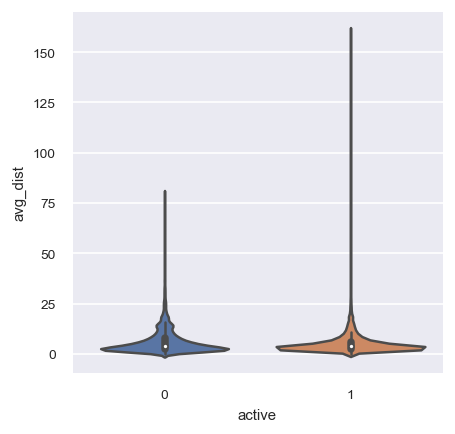

In [20]:
# Visualize difference in average distance by activity of user
fig, ax = pp.subplots(figsize=(4, 4), dpi=120)
sns.violinplot(data=df,x='active',y='avg_dist', ax=ax);

In [21]:
pd.pivot_table(df,index='active',aggfunc={'avg_dist':['mean','std']})

avg_dist          
            mean       std
active                    
0       6.190725  6.184010
1       5.113930  4.617779

There is a difference in the average distance per trip taken in the first 30 days between active users and inactive users, this will be important for predictive modeling.

The average rating by by driver will probably be informative, let's plot it for active vs inactive users.

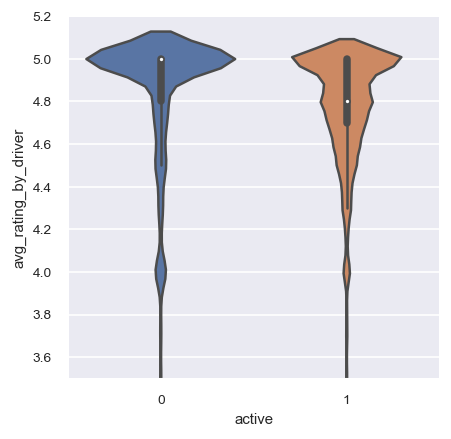

In [22]:
fig, ax = pp.subplots(figsize=(4, 4), dpi=120)
sns.violinplot(data=df,x='active',y='avg_rating_by_driver', ax=ax)
pp.ylim([3.5,5.2]);

In [23]:
pd.pivot_table(df,index='active',aggfunc={'avg_rating_by_driver':['median','std']})

avg_rating_by_driver          
                     median       std
active                               
0                       5.0  0.503901
1                       4.8  0.328753

Interestingly, active users have a lower rating than inactive users, perhaps because active users are more likely to have more total trips and therefore a higher chance of doing something to make the drivers give them a rating less than 5. It seems this feature will be important for predictive modeling.

In [24]:
pd.pivot_table(df,index='active',aggfunc={'trips_in_first_30_days':['mean','std']})

trips_in_first_30_days          
                         mean       std
active                                 
0                    1.657033  2.655767
1                    3.304804  4.985057

Active users took more trips in their first 30 days. It is not important to verify this using hypothesis testing, because we only want to see the trend and what will be useful for our predictive model.

**Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.**

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [26]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(df_features, target, test_size=0.2,random_state=42)

In [27]:
# Scale data
scaler = QuantileTransformer()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [28]:
# Build random forest model with 1000 estimators
rf = RandomForestClassifier(n_estimators=1000, oob_score=True)
rf.fit(X_train_sc,y_train)
y_pred = rf.predict(X_test_sc)

In [29]:
rf.oob_score_

0.7575032129627296

In [30]:
df_importance = pd.DataFrame(zip(list(df_features.columns),rf.feature_importances_),index=range(df_features.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.300055
4,weekday_pct,0.132821
6,avg_rating_by_driver,0.114951
1,avg_rating_of_driver,0.081798
0,trips_in_first_30_days,0.080390
3,surge_pct,0.078927
2,avg_surge,0.065090
8,city_King's Landing,0.047401
10,phone_Android,0.020123
11,phone_iPhone,0.019286


City, phone type, and ultimate black user stats are all relatively unimportant for the model compared to average distance driven, weekday percentage, and the rating given to the passenger by the driver.

In [31]:
# Generate confusion matrix
confusion_matrix(y_test,y_pred)

array([[4962, 1238],
       [1238, 2483]], dtype=int64)

75% accuracy is a good start, however let us try a logistic regression model with some hyper parameter tuning, since we already have an idea of the feature importances from the random forest model.

In [32]:
# Initialize model
logit = LogisticRegression()
# Set parameter grid
param_grid = {'C':np.arange(0.5,5.1,0.1)}
# Instantiate and fit grid search object
grid = GridSearchCV(logit, param_grid, cv=5)
grid.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
       1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ,
       3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3,
       4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])})

In [33]:
# Find coefficients from Logistic Regression
logit_coef = grid.best_estimator_
logit_coef.fit(X_train_sc, y_train)
df_coef = pd.DataFrame(zip(list(df_features.columns),logit_coef.coef_[0]),index=range(df_features.columns.shape[0]),columns=['feature','coefficient'])
df_coef['coefficient'] = df_coef.coefficient.abs()
df_coef.sort_values(by='coefficient', ascending=False)

,feature,coefficient
2,avg_surge,2.446497
3,surge_pct,1.372131
6,avg_rating_by_driver,1.342490
8,city_King's Landing,1.119643
7,city_Astapor,0.767688
11,phone_iPhone,0.588591
13,ultimate_black_user_True,0.515857
10,phone_Android,0.484810
12,ultimate_black_user_False,0.412076
1,avg_rating_of_driver,0.366691


We have not gained any advantage using Logistic Regression for our classifier, the models perform almost identically. 

In conclusion, we have extracted very valuable information from this dataset. First, we have built a predictive model with 75% accuracy, that will be useful for future prediction. Secondly, the insights from the model are arguably more important and lucrative for the company. Random Forest has given us the most important features and Logistic Regression shows us the effect of the features through the coefficients. Taking the three most important features, we can see the following effects on the "activity" of a rider after 6 months.

**Average distance:** This one is tricky because while our logistic regression model shows that an increase in average distance per trip in the first 30 days increases our chances of being an active user, interestingly, the mean avg_dist is larger for inactive riders than for active. Due to this ambiguity in the data, it may not be advisable to try to increase the distance of trips taken in the first 30 days.

**Weekday percentage:** The chance of being an active user decrease as the percentage of week day use goes up. From this we can see that encouraging people to use the app on the weekend will be beneficial for the company revenue.

**Average rating by driver:** For this feature, there is a decreased likelihood of being an active user as your rating goes up.

**Trips in the first 30 days:** As the number of trips in the first 30 days increases, so does the chance that a rider is active after 6 months.

Based on these insights gained from the model, there are several recomendations for the company.